# 2. Leaky Aquifer Recovery Test - Hardixveld Example
**This test is taken from MLU examples.**

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim as ttm

plt.rcParams["figure.figsize"] = [5, 3]

## Introduction and Conceptual Model

This test was taken in Hardinxveld-Giessendam, Netherlands, in 1981 to quantify the head-loss at each pumping well by clogging and to assess the transmissivity variation in the area.

The hydrogeological conceptualization can be described as the following:
* The first ten meters depth is an aquitard
* Followed by the first aquifer from 10 to 37 m depth, this is also the test aquifer.
* A new aquitard is present from 37 m depth to 68 m depth
* A final aquifer is from 68 to 88 m depth.
* Below 88 m depth the formations are considered an aquiclude

Five pumping wells are screened in the first aquifer. The drawdown of one of them is available in the MLU documentation (Carlson & Randall, 2012).
The provided pumping well was operated for 20 minutes at 1848 m3/d. Drawdown was recorded for a total of 50 minutes during and after pumping. The radius of the pumped well is 0.155 m.

In this notebook, we reproduce the work of Xinzhu (2020) and demonstrate the use of TTim to fit a recovery test and quantify the skin resistance in the well and the hydraulic parameters of the aquifer.

The following figure summarises the hydrogeological conceptual model.

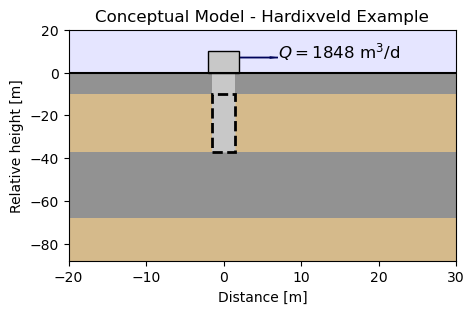

In [2]:
import matplotlib.pyplot as plt

##Now printing the conceptual model figure:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-20, 0), width=50, height=20, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-20, -37),
    width=50,
    height=27,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

# Aquifer 2:
ground2 = plt.Rectangle(
    (-20, -88),
    width=50,
    height=20,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground2)

# Confining bed:
confining_unit = plt.Rectangle(
    (-20, -10),
    width=50,
    height=10,
    fc=np.array([100, 100, 100]) / 255,
    zorder=0,
    alpha=0.7,
)
ax.add_patch(confining_unit)

confining_unit2 = plt.Rectangle(
    (-20, -68),
    width=50,
    height=31,
    fc=np.array([100, 100, 100]) / 255,
    zorder=0,
    alpha=0.7,
)
ax.add_patch(confining_unit2)

well = plt.Rectangle(
    (-1.5, -37), width=3, height=37, fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle(
    (-2, 0), width=4, height=10, fc=np.array([200, 200, 200]) / 255, zorder=2, ec="k"
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-1.5, -37),
    width=3,
    height=27,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=2, y=7, dx=5, dy=0, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=7, y=7, s=r"$ Q = 1848$ m$^3$/d", fontsize="large")

# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="k")
ax.add_line(line)


ax.set_xlim([-20, 30])
ax.set_ylim([-88, 20])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model - Hardixveld Example");

### Basic parameters

In [3]:
H = 27  # aquifer thickness, m
zt = -10  # upper boundary of aquifer, m
zb = zt - H  # lower boundary of the aquifer, m
rw = 0.155  # well screen radius, m
Q = 1848  # constant discharge rate, m^3/d
t0 = 0.013889  # time stop pumping, d

### Load data for the recovery test

Data is saved in a text file where the first column is the time data in days and in the second is the drawdown in m

In [4]:
data = np.loadtxt("data/recovery.txt", skiprows=1)
to = data[:, 0]
ho = data[:, 1]

### Conceptual model

Here we create a two aquifer leaky model in ModelMaq, so we have to define the top of the first aquitard layer, followed by the tops and bottoms of the aquifer layers. Here we ignore storage (```Sll```) of the aquitard layers.

The well is defined with skin resistance (```res```) and the pumping schedule with the start and shutdown of the pump.

In [5]:
ml1 = ttm.ModelMaq(
    kaq=[50, 40],
    z=[0, zt, zb, -68, -88],
    c=[1000, 1000],
    Saq=[1e-4, 5e-5],
    topboundary="semi",
    tmin=1e-4,
    tmax=0.04,
)
w1 = ttm.Well(ml1, xw=0, yw=0, rw=rw, res=1, tsandQ=[(0, Q), (t0, 0)], layers=0)
ml1.solve()

self.neq  1
solution complete


### Calibration

The parameters to be calibrated are the hydraulic conductivity and specific storage of the first layer, and the skin resistance of the well. The parameters of the aquitards and the second aquifer are kept fixed.

In [6]:
ca1 = ttm.Calibrate(ml1)
ca1.set_parameter(name="kaq0", initial=50, pmin=0)
ca1.set_parameter(name="Saq0", initial=1e-4, pmin=0)
ca1.set_parameter_by_reference(name="res", parameter=w1.res[:], initial=1, pmin=0)
ca1.seriesinwell(name="obs", element=w1, t=to, h=ho)
ca1.fit()

.....................................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.


In [7]:
display(ca1.parameters.loc[:, ["optimal"]])
print("RMSE:", ca1.rmse())

,optimal
kaq0,44.529551
Saq0,0.000006
res,0.016205


RMSE: 0.005511886856381756


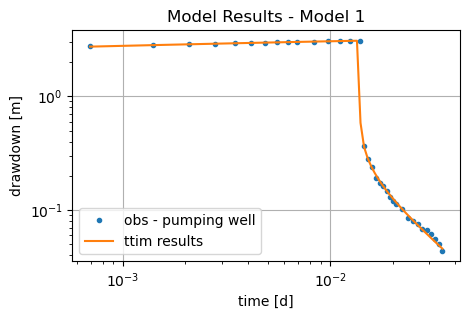

In [8]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm1 = w1.headinside(tm)
plt.loglog(to, -ho, ".", label="obs - pumping well")
plt.loglog(tm, -hm1[0], label="ttim results")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.legend()
plt.title("Model Results - Model 1")
plt.grid()

Overall a good fit has been observed.

### Testing single layer model

As an alternative of simpler model, we will test the assumption that we can neglect the effect of the semi-confining top layer and the underlying aquifer. Thus, we simulate the aquifer as confined.

Therefore this model is a single layer semi-confined aquifer that only includes the top aquitard and the first aquifer. In the well, we are not considering the ```rc``` parameter.

In [9]:
ml0 = ttm.ModelMaq(kaq=50, z=[zt, zb], Saq=1e-4, topboundary="conf", tmin=1e-4, tmax=0.04)
w0 = ttm.Well(ml0, xw=0, yw=0, rw=rw, res=1, tsandQ=[(0, Q), (t0, 0)], layers=0)
ml0.solve()

self.neq  1
solution complete


### Calibration

In the calibration we repeat the procedure for model 1.

In [10]:
ca0 = ttm.Calibrate(ml0)
ca0.set_parameter(name="kaq0", initial=50, pmin=0)
ca0.set_parameter(name="Saq0", initial=1e-4, pmin=0)
# ca0.set_parameter(name="c0", initial=1000, pmin=10, pmax=10000)
ca0.set_parameter_by_reference(name="res", parameter=w0.res[:], initial=1)
ca0.seriesinwell(name="obs", element=w0, t=to, h=ho)
ca0.fit()

..............................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.


In [11]:
display(ca0.parameters.loc[:, ["optimal"]])
print("RMSE:", ca0.rmse())

,optimal
kaq0,48.653125
Saq0,0.000076
res,0.022092


RMSE: 0.00873670055844304


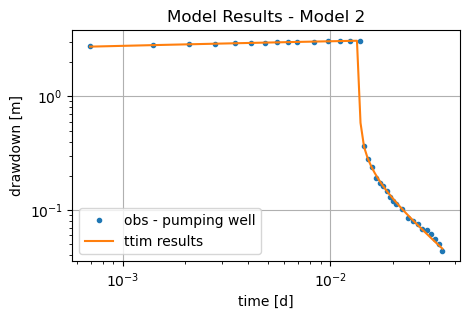

In [12]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm1 = w1.headinside(tm)
plt.loglog(to, -ho, ".", label="obs - pumping well")
plt.loglog(tm, -hm1[0], label="ttim results")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.legend()
plt.title("Model Results - Model 2")
plt.grid()

The fit is still very good. 

### Analysis and summary of values

In [13]:
ta = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "res"],
    index=["MLU", "TTim-single layer", "TTim-two layers"],
)
ta.loc["TTim-single layer"] = ca0.parameters["optimal"].values
ta.loc["TTim-two layers"] = ca1.parameters["optimal"].values
ta.loc["MLU"] = [51.530, 8.16e-04, 0.022]
ta["RMSE [m]"] = [0.00756, ca0.rmse(), ca1.rmse()]
ta

,k [m/d],Ss [1/m],res,RMSE [m]
MLU,51.53,0.000816,0.022,0.007560
TTim-single layer,48.653125,0.000076,0.022092,0.008737
TTim-two layers,44.529551,0.000006,0.016205,0.005512


Both TTim models agree with each other with similar parameters. MLU parameters are higher than the ones in TTim.

## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B., Ingargiola, A. (2014) LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python.https://dx.doi.org/10.5281/zenodo.11813. https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.